# Sparkify Project Workspace
By Thierry Bemelmans as part of my Udacity Data Science Nano Degree

## Project Overview & Background
This workbook was developped in the context of my Udacity Data Science Nano Degree final project "Sparkify". 
It aims at leveraging key learned Data Science skills and the powerful capabilities of Python & Spark to load, explore, cleanse and prepare the large "Sparkiy" song event dataset to engineer and tune a machine learning model to predict customer churn. 

<b>The Sparkify dataset</b> is anchored in the music streaming services similar to Spotify. Customers use their mobile devices or computer to browse a music libary, listen to music. They need first to register to the service, then they can either use the 'free' service tier with advertising, no offline mode and restricted use or later upgrade and subscribe to the full experience with a monthly fee. The company aims to maximise their revenue by increasing their subscriptions and also minimizing the customer "churn", when they cancel their account. To minimize the churn, the company would like to develop a machine learning model to predict when a customer would be likely to downgrade or cancel their registration and trigger incentivizing marketing tactics to prevent the churn.

The data consists of events recorded when the user login, register, jump to different songs, upgrade, downgrade or cancel their registration.
<br>We will start with a 12MB size small sample of the full data set to explore the data, its key features and iteratively develop our ML model. 
We will then leverage our learning to scale an optimized model to the full 12GB data set.


## Problem Statement & Solutioning Strategy
The problem to be solved is to train, test and tune a machine learning model to predict the customer at risks of 'churn' i.e. downgrading/cancelling their subscriptions so marketing strategies can optimize the subscription revenues.

We will follow this overal strategy for solving the problem & develop the expected solution:
<ol>
<li><b>LOAD AND CLEAN DATA SET:</b> Load the datafile to a Spark dataframe, analyze its schema, discover its fields, field type/content/data quality and cleanse the data. The fields will also help us to refine our strategy by identifying the high/low value fields to focus on.
</li><li><b>EDA - EXPLORATORY DATA ANALYSIS:</b> on churn and user behaviours linked to churn.
</li><li><b>FEATURE ENGINEERING</b> to transform the original cleanse data set to be ready to train and test the machine learning model
</li><li><b>MODELING & TUNING</b> by selecting the best machine learning algorithm and related parameters that maximize the model accuracy.
</li><li><b>MAKE THE MODEL USABLE</b>
</li><li><b>CONCLUSION</b> of the project and key findings
</ol>


## Metrics To Measure the ML Model Performance
The ML model to develop is a typical binary classifier: is a user either likely to churn (1) or not (0)?
Intuitively, the accuracy of a predictions vs the actual values seems to be a great way to measure our model performance.... But is it?  
<br>It works well in a balanced data set, where the actual values are fairly well distributed between the 2 binary values. If the dataset is imbalanced between the binary options, other performance metrics will be used. For further understanding, please refer to this excellent article from Jason Brownlee on measuring performnance of skewed datasets : https://machinelearningmastery.com/failure-of-accuracy-for-imbalanced-class-distributions.
<br><br>As we sill see in our analysis, our dataset has 77% of the users not churning vs 23% churning... therefore a model returning all users as NOT churning would already have accuracy of 77%, but would be totally useless. 
<br>Therefore we will use the F1-Score to measure this skewed binary classification, it combines both "Precision" and "Recall" measures. For further details on the F1 Score calculation, see this great article from deepai.org: https://deepai.org/machine-learning-glossary-and-terms/f-score with the following definitions:
- <i>"<b>Precision</b> is the fraction of true positive examples among the examples that the model classified as positive. In other words, the number of true positives divided by the number of false positives plus true positives."</i>
- <i>"<b>Recall</b>, also known as sensitivity, is the fraction of examples classified as positive, among the total number of positive examples. In other words, the number of true positives divided by the number of true positives plus false negatives."</i>

## Technical Set Up
I leveraged the AWS Glue Spark 3.1 Docker container on my laptop to fast-track this development. I found it extremelly useful to iteratively develop Spark Python code with a Jupyter notebook directly on my laptop. I already used the same approach at work, learning the trick from AWS. See this blog on how to set up your own machine. 
https://aws.amazon.com/blogs/big-data/develop-and-test-aws-glue-version-3-0-jobs-locally-using-a-docker-container/
<br><br>The same notebook code was also tested on the Udacity virtual machine that uses Spark version 2.4.

# 1.Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat,count, desc, explode, lit, min, max, split, stddev, udf
from pyspark.sql.types import IntegerType
from pyspark.sql import Window
from pyspark.sql import functions as F
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark import sql
import time
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Creating Features") \
    .getOrCreate()

print('PySpark Version :' + spark.version)

PySpark Version :3.1.1-amzn-0


In [3]:
filePath = 'mini_sparkify_event_data.json'
df = spark.read.json(filePath)
df.createOrReplaceTempView("event_table")
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

Lets understand Data Fields, Data Types, Stats, Data Quality

In [4]:
# Data Shape
print(f'Data Frame Shape: {df.count()} rows, {len(df.columns)} fields')

Data Frame Shape: 286500 rows, 18 fields


In [5]:
# Fields & data types
print(df.printSchema())

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

None


In [6]:
# Show me first rows to better grasp the data
print(df.show(n=5))

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [7]:
# Check for N/A or nulls
from pyspark.sql.functions import col,isnan,when,count
rows_count = df.count()
print(f'Total rows: {rows_count}')
print('For each field, count of either None or Null or blanks')
df2 = df.select([count(when((col(c) == '' )|(col(c).isNull()), c)).alias(c) for c in df.columns])
print(df2.show())

Total rows: 286500
For each field, count of either None or Null or blanks
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|  8346|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+

None


### Data Cleansing
We will now look at rows with null values in the userId and evaluate how many of them we have. 
<br>If makes sense, we will remove them them to cleanse the data.

In [8]:
# Check which page(s) have null for user ID
df2 = df.filter((df.userId.isNull())| (df.userId == "")).groupBy("page").count().show()

+-------------------+-----+
|               page|count|
+-------------------+-----+
|              Error|    6|
|               Help|  272|
|               Home| 4375|
|              About|  429|
|Submit Registration|    5|
|              Login| 3241|
|           Register|   18|
+-------------------+-----+



The pages without userID are the ones when non-yet-registered or not-yet-logged-in users land on the portal. Those events & pages would not be useful for our ML analysis on the user churn as missing the userId. Therefore we will drop those rows as we will segregate users that churn or not and the userId field must be filled for it. 

In [9]:
# remove rows with null or blan user ID
count_prior_removal = df.count()
df = df.filter((df.userId.isNotNull())&(df.userId != ""))
count_removed = count_prior_removal - df.count()
dropPercentage = 100* count_removed / count_prior_removal
print(f'{count_removed} rows ({dropPercentage:1.1f})% found with null userID out of {count_prior_removal} rows cleansed')
df.createOrReplaceTempView('event_table_clean')

8346 rows (2.9)% found with null userID out of 286500 rows cleansed


In [10]:
# now check if duplicated rows in our dataset
print(f'Total row count: {df.count()} Total unique rows: {df.drop_duplicates().count()}')

Total row count: 278154 Total unique rows: 278154


That is great, no duplication as both row count matches.

# 2.EDA - Exploratory Data Analysis
Loading a small data set sample, the hereunder EDA - Exploratory Data Analysis will do basic data manipulations within Spark, to understand the different fields, analyse and and visualize their content to get further insights on how they should be used for either the ML outcome or features preparation & modeling.

<br><b>Define Churn</b>: a column `churn` will be used as a binary label for our model. The `Cancellation Confirmation` events to define our churn, which happen for both paid and free users. The `Downgrade` events could also be modeled in a next phase as a ML classifications with  multiple labels problem vs just binary.  For the sake of time, we will focus on the binary problem.

<br><b>Explore Data</b>:Once the 'churn' has been defined, exploratory data analysis will be performed to observe the behavior for users who stayed vs users who churned, aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### Analyse key fields, number of distinct values and for smaller sets, list the values found.

In [11]:
# Check each fields: Count distinct values per field
# to identify categorical columns & if list of distinct value < 30, show the list of distinct values
from pyspark.sql.functions import countDistinct
for col in df.columns:
    uniqueValues = df.select(countDistinct(col)).collect()[0][0]
    # get list of values if small set (<30)
    if uniqueValues < 30:
        listOfValues = df.select(col).distinct().rdd.flatMap(lambda x: x).collect()
    else:
        listOfValues = ''
    print(f'{col}\t{uniqueValues}\t {listOfValues}')

artist	17655	 
auth	2	 ['Cancelled', 'Logged In']
firstName	189	 
gender	2	 ['M', 'F']
itemInSession	1311	 
lastName	173	 
length	14865	 
level	2	 ['free', 'paid']
location	114	 
method	2	 ['GET', 'PUT']
page	19	 ['Downgrade', 'Save Settings', 'Error', 'Add to Playlist', 'Help', 'Submit Upgrade', 'Cancel', 'Submit Downgrade', 'Thumbs Down', 'Home', 'Roll Advert', 'About', 'Upgrade', 'Cancellation Confirmation', 'NextSong', 'Thumbs Up', 'Logout', 'Settings', 'Add Friend']
registration	225	 
sessionId	2312	 
song	58480	 
status	3	 [200, 404, 307]
ts	269770	 
userAgent	56	 
userId	225	 


### Fields Insights from observed values:
<lt><li>Fields with categorical values</b>: auth, gender, level, method, page, status.
</li><li><b>The field</b> "page" </b>seems very interesting, to tell us about the user flow / sequence of events when using the service.
</li><li><b>Fields for outcome analytics</b> : level, page if 'Submit Downgrade', ' Downgrade', 'Cancellation Confirmation', 'Submit Upgrade'
</li><li><b>Fields for features</b>: will need further deepdive on the data.
</li></lt>

### Events per page

+--------------------+------+
|                page| count|
+--------------------+------+
|Cancellation Conf...|    52|
|              Cancel|    52|
|    Submit Downgrade|    63|
|      Submit Upgrade|   159|
|               Error|   252|
|       Save Settings|   310|
|               About|   495|
|             Upgrade|   499|
|                Help|  1454|
|            Settings|  1514|
|           Downgrade|  2055|
|         Thumbs Down|  2546|
|              Logout|  3226|
|         Roll Advert|  3933|
|          Add Friend|  4277|
|     Add to Playlist|  6526|
|                Home| 10082|
|           Thumbs Up| 12551|
|            NextSong|228108|
+--------------------+------+

None


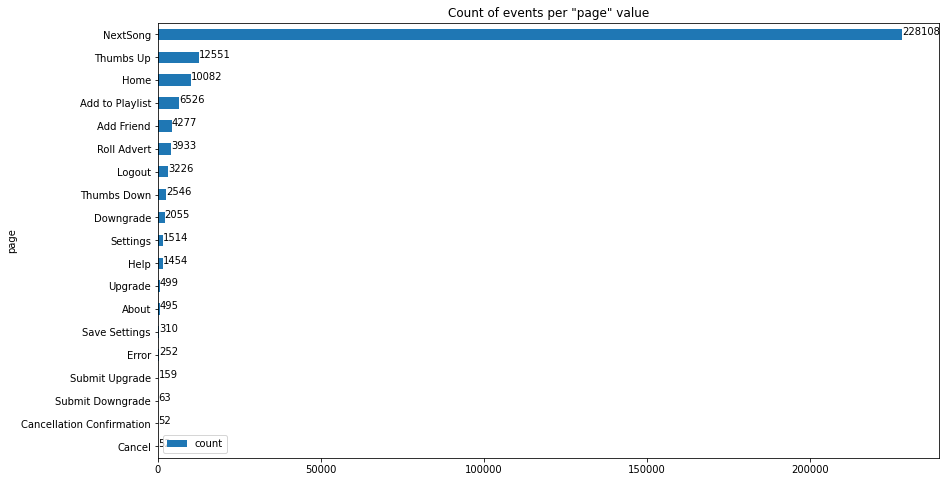

In [12]:
# distribution of events per page / per user
# what type of page have no registration?
df4 = spark.sql("select page, count(*) as count from event_table_clean group by page order by count(*)")
print(df4.show(n=30))
df_panda = df4.toPandas()
# visualize now
# Matplotlib documentation on https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.barh.html#:~:text=A%20horizontal%20bar%20plot%20is,axis%20represents%20a%20measured%20value.
fig, ax = plt.subplots(figsize=(14, 8))
df_panda.plot.barh(x='page', y='count', ax=ax)

# add label of value, see doc https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.text.html
for idx, value in enumerate(df_panda['count']):
    plt.text(value, idx, value)

plt.title('Count of events per "page" value')
plt.show()


Insights on page: the 'Next sond' is the most frequent event, 'cancellation confirmation' is relatively very small. Other interesting events could be used also in the churn prediction, like "Thumbs Up", "Add to playlist", "Submit Downgrade", ...

## How to define our desired outomes for the model: user churn?
Our business objective is to detect users that are more likely to leave the service, i.e. to churn vs not churn. This is a binary classification problem. The model should give us the probability of each user at a given time, given their history to be part of the users who churn or not.
<br><br>We will first look at how many users we have in total and how many of them got
<lt><li>"downgraded": have an event with the field 'page' = 'Submit Downgrade'
</li><li>"churn": have an event with the field 'page' = 'Cancellation Confirmation'
</li></lt>

In [13]:
downgrade_user_list = df.filter("page = 'Submit Downgrade'").select('userId').distinct().rdd.flatMap(lambda x: x).collect()
cancel_user_list = df.filter("page = 'Cancellation Confirmation'").select('userId').distinct().rdd.flatMap(lambda x: x).collect()
all_user_list = df.select('userId').distinct().rdd.flatMap(lambda x: x).collect()

print(f'Downgraded user count:\t{len(downgrade_user_list)}')
print(f'Cancelled user count:\t{len(cancel_user_list)}')
print(f'All user count:\t{len(all_user_list)}')

Downgraded user count:	49
Cancelled user count:	52
All user count:	225


In [14]:
# put 1 for all users with churn at least once and 0 if no churn. to use as outcome label for the ML classification.
isChurn = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df = df.withColumn('churn', isChurn(df['page']))
window = Window.partitionBy("UserId")
df = df.withColumn('churn_user', max(df['churn']).over(window))
print(df.where(df['userId'] == 51).select('page','churn', 'churn_user', 'ts').orderBy(df['ts'].desc()).show())
df.createOrReplaceTempView('event_table_clean')

+--------------------+-----+----------+-------------+
|                page|churn|churn_user|           ts|
+--------------------+-----+----------+-------------+
|Cancellation Conf...|    1|         1|1539761972000|
|              Cancel|    0|         1|1539761830000|
|            Settings|    0|         1|1539761829000|
|            NextSong|    0|         1|1539761726000|
|            NextSong|    0|         1|1539761508000|
|            NextSong|    0|         1|1539761269000|
|            NextSong|    0|         1|1539761030000|
|            NextSong|    0|         1|1539760849000|
|            NextSong|    0|         1|1539760549000|
|            NextSong|    0|         1|1539760052000|
|            NextSong|    0|         1|1539759811000|
|            NextSong|    0|         1|1539759645000|
|            NextSong|    0|         1|1539759362000|
|           Thumbs Up|    0|         1|1539759213000|
|            NextSong|    0|         1|1539759212000|
|            NextSong|    0|

## Quick exploration/ visualization of the key data fields

### Events per gender & level

+------+------+
|gender| count|
+------+------+
|     M|123576|
|     F|154578|
+------+------+

None
+-----+------+
|level| count|
+-----+------+
| free| 55721|
| paid|222433|
+-----+------+

None


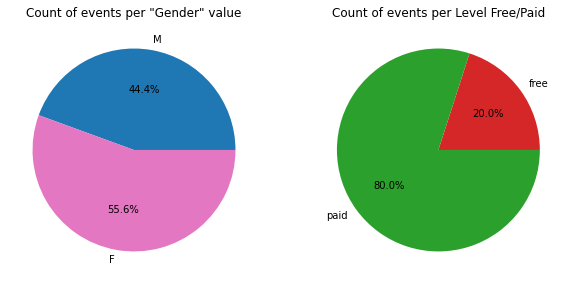

In [15]:
# distribution of events per gender
df_gender = spark.sql("select gender, count(*) as count from event_table_clean group by gender order by count(*)")
df_level = spark.sql("select level, count(*) as count from event_table_clean group by level order by count(*)")
print(df_gender.show(n=30))
print(df_level.show(n=30))

# visualize now
# Matplotlib documentation on https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.barh.html#:~:text=A%20horizontal%20bar%20plot%20is,axis%20represents%20a%20measured%20value.
fig, ax = plt.subplots(nrows=1, ncols=2, figsize =(10, 5))

# left chart
df_gender_panda = df_gender.toPandas()
my_color = [ 'tab:blue', 'tab:pink']
ax[0].pie(df_gender_panda['count'], labels = df_gender_panda['gender'], colors=my_color,  autopct='%.1f%%')
ax[0].title.set_text('Count of events per "Gender" value')

# Right chart
# Axes.barh(y, width, height=0.8, left=None, *, align='center', data=None, **kwargs)
df_level_panda = df_level.toPandas()
my_color = [ 'tab:red', 'tab:green']
ax[1].pie(df_level_panda['count'], labels = df_level_panda['level'], colors=my_color,  autopct='%.1f%%')
ax[1].title.set_text('Count of events per Level Free/Paid')

plt.show()

### Artists and Songs Analysis

In [16]:
# count of artists and songs
artist_count = df.select('artist').drop_duplicates().count()
song_count = df.select('song').drop_duplicates().count()
print(f'{artist_count} artists\t{song_count} songs\tAverage songs/artist: {song_count / artist_count:1.1f}')

17656 artists	58481 songs	Average songs/artist: 3.3


In [17]:
# count of most played artist
df1 = df.where(df["page"] ==  "NextSong").groupBy("artist").count()
df1.sort(df1["count"].desc()).show(n=10)

+--------------------+-----+
|              artist|count|
+--------------------+-----+
|       Kings Of Leon| 1841|
|            Coldplay| 1813|
|Florence + The Ma...| 1236|
|       Dwight Yoakam| 1135|
|            BjÃÂ¶rk| 1133|
|      The Black Keys| 1125|
|                Muse| 1090|
|       Justin Bieber| 1044|
|        Jack Johnson| 1007|
|              Eminem|  953|
+--------------------+-----+
only showing top 10 rows



In [18]:
# Top 10 songs and artist played
df1 = df.where(df["page"] ==  "NextSong").groupBy("artist", "song").count()
df1.sort(df1["count"].desc()).show(n=10)

+--------------------+--------------------+-----+
|              artist|                song|count|
+--------------------+--------------------+-----+
|       Dwight Yoakam|      You're The One| 1122|
|            BjÃÂ¶rk|                Undo| 1026|
|       Kings Of Leon|             Revelry|  854|
|            Harmonia|       Sehr kosmisch|  728|
|Barry Tuckwell/Ac...|Horn Concerto No....|  641|
|Florence + The Ma...|Dog Days Are Over...|  574|
|         OneRepublic|             Secrets|  463|
|       Kings Of Leon|        Use Somebody|  459|
|    Five Iron Frenzy|              Canada|  434|
|            Tub Ring|             Invalid|  424|
+--------------------+--------------------+-----+
only showing top 10 rows



### Geolocation Analysis & Data Preparation

In [19]:
# show me the top 10 locations to better grasp the data
df4 = df.groupBy("location").count()
df4.sort(df4['count'].desc()).show(n=10, truncate=False)

+-------------------------------------------+-----+
|location                                   |count|
+-------------------------------------------+-----+
|Los Angeles-Long Beach-Anaheim, CA         |30131|
|New York-Newark-Jersey City, NY-NJ-PA      |23684|
|Boston-Cambridge-Newton, MA-NH             |13873|
|Houston-The Woodlands-Sugar Land, TX       |9499 |
|Charlotte-Concord-Gastonia, NC-SC          |7780 |
|Dallas-Fort Worth-Arlington, TX            |7605 |
|Louisville/Jefferson County, KY-IN         |6880 |
|Philadelphia-Camden-Wilmington, PA-NJ-DE-MD|5890 |
|Chicago-Naperville-Elgin, IL-IN-WI         |5114 |
|St. Louis, MO-IL                           |4858 |
+-------------------------------------------+-----+
only showing top 10 rows



Location seems to follow the pattern "city, state" for the USA country. We will split those data into 2 fields to better mine the geolocation

In [20]:
# lets split the location in city and state
df = df. withColumn('state', split('location', ', ')[1]).withColumn('city', split('location', ', ')[0])
print(df.select('location', 'city', 'state').show(n=4, truncate=False))
# What are the top states?
df.groupby('state').count().orderBy('count').show(n=10)

+------------------------------+-----------------------+-----+
|location                      |city                   |state|
+------------------------------+-----------------------+-----+
|Bakersfield, CA               |Bakersfield            |CA   |
|Boston-Cambridge-Newton, MA-NH|Boston-Cambridge-Newton|MA-NH|
|Bakersfield, CA               |Bakersfield            |CA   |
|Boston-Cambridge-Newton, MA-NH|Boston-Cambridge-Newton|MA-NH|
+------------------------------+-----------------------+-----+
only showing top 4 rows

None
+--------+-----+
|   state|count|
+--------+-----+
|      OR|   23|
|TN-MS-AR|   62|
|OH-KY-IN|   88|
|   OR-WA|  119|
|   NE-IA|  187|
|   VA-NC|  246|
|   UT-ID|  317|
|      AR|  520|
|      IA|  651|
|      SC|  668|
+--------+-----+
only showing top 10 rows



### Time Series analysis
This section evaluate if the hour, day of the week, month, year of the event could play a role in the data

In [21]:
from pyspark.sql.functions import date_format, to_date
from pyspark.sql.types import TimestampType
# ts is in epoc format milliseconds => /1000 to convert to seconds
df = df.withColumn('ts_timestamp', date_format((df.ts / 1000).cast(dataType=TimestampType()), 'yyyy-MM-dd hh:mm'))
df = df.withColumn('ts_yyyy_mm_dd', date_format((df.ts / 1000).cast(dataType=TimestampType()), 'yyyy-MM-dd'))
# hh is 12h format, HH is 24 hour format
df = df.withColumn('ts_hour', date_format((df.ts / 1000).cast(dataType=TimestampType()), 'HH'))
df = df.withColumn('ts_day_of_month', date_format((df.ts / 1000).cast(dataType=TimestampType()), 'dd'))

# u.EEEE to have first the numerical weekday(u) then the wordy one(EEEE) to order it by day & not alphabetically
df = df.withColumn('ts_day_of_week', date_format((df.ts / 1000).cast(dataType=TimestampType()), 'E'))
df = df.withColumn('ts_month', date_format((df.ts / 1000).cast(dataType=TimestampType()), 'MM'))
df = df.withColumn('ts_year', date_format((df.ts / 1000).cast(dataType=TimestampType()), 'yyyy'))
df = df.withColumn('ts_year_month', date_format((df.ts / 1000).cast(dataType=TimestampType()), 'yyyy-MM'))

df.select('ts', 'ts_timestamp', 'ts_yyyy_mm_dd', 'ts_hour', 'ts_day_of_month', 'ts_day_of_week', 'ts_month', \
          'ts_year', 'ts_year_month').show(n=20)
df.createOrReplaceTempView('event_table_clean')

+-------------+----------------+-------------+-------+---------------+--------------+--------+-------+-------------+
|           ts|    ts_timestamp|ts_yyyy_mm_dd|ts_hour|ts_day_of_month|ts_day_of_week|ts_month|ts_year|ts_year_month|
+-------------+----------------+-------------+-------+---------------+--------------+--------+-------+-------------+
|1538352117000|2018-10-01 12:01|   2018-10-01|     00|             01|           Mon|      10|   2018|      2018-10|
|1538352180000|2018-10-01 12:03|   2018-10-01|     00|             01|           Mon|      10|   2018|      2018-10|
|1538352394000|2018-10-01 12:06|   2018-10-01|     00|             01|           Mon|      10|   2018|      2018-10|
|1538352416000|2018-10-01 12:06|   2018-10-01|     00|             01|           Mon|      10|   2018|      2018-10|
|1538352676000|2018-10-01 12:11|   2018-10-01|     00|             01|           Mon|      10|   2018|      2018-10|
|1538352678000|2018-10-01 12:11|   2018-10-01|     00|          

In [22]:
# Lets check our time range min-max
spark.sql("Select min(ts_timestamp) as min_time, max(ts_timestamp) as max_time from event_table_clean").show()

+----------------+----------------+
|        min_time|        max_time|
+----------------+----------------+
|2018-10-01 01:00|2018-12-03 01:11|
+----------------+----------------+



You can see that the data only spans over about 2 months. This is relatively small and any predictions or interpretations on such a small period need to be taken with prudence.

### Lets visualize our events counts / churn count trending per day, day of week and hour of day

+-------------+-----+
|ts_yyyy_mm_dd|count|
+-------------+-----+
|   2018-10-01| 4286|
|   2018-10-02| 4453|
|   2018-10-03| 3966|
|   2018-10-04| 4645|
|   2018-10-05| 4485|
+-------------+-----+
only showing top 5 rows

None
+--------------+-----+
|ts_day_of_week|count|
+--------------+-----+
|           Fri|48173|
|           Mon|43252|
|           Sat|28027|
|           Sun|21050|
|           Thu|44320|
+--------------+-----+
only showing top 5 rows

None


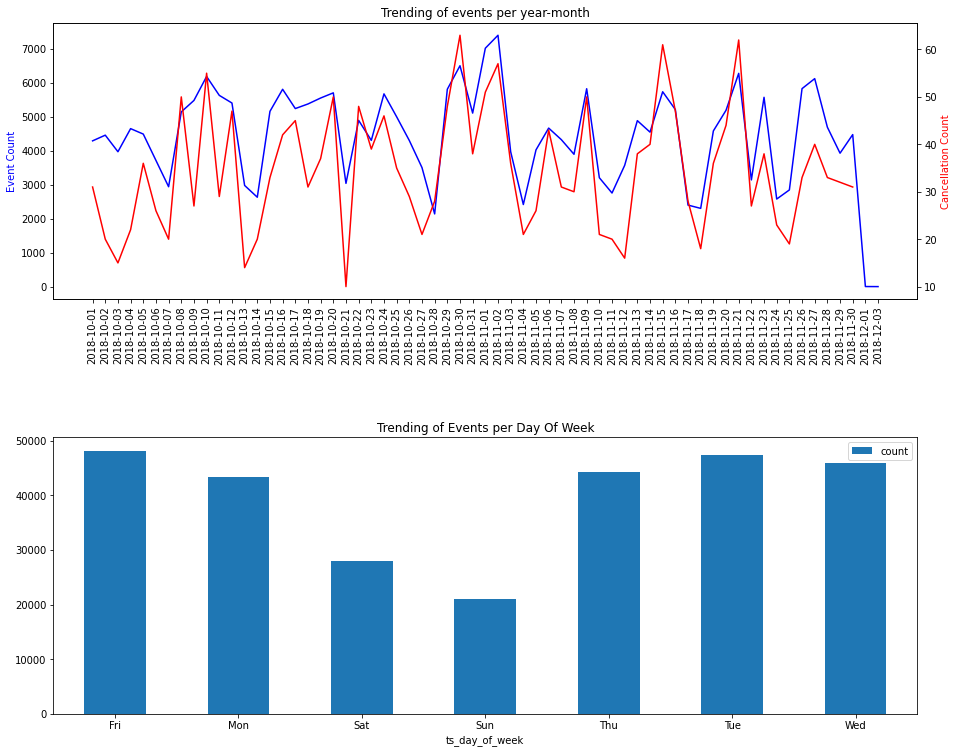

In [23]:
df.createOrReplaceTempView('event_table_cleaned')
df4 = spark.sql("select ts_yyyy_mm_dd, count(*) as count from event_table_cleaned group by ts_yyyy_mm_dd order by ts_yyyy_mm_dd")
print(df4.show(n=5))
df_panda = df4.toPandas()
df_downgrade_cancel = spark.sql("select ts_yyyy_mm_dd, count(*) as count from event_table_cleaned where page in ('Downgrade', 'Cancel') group by ts_yyyy_mm_dd order by ts_yyyy_mm_dd")
df_downgrade_cancel_pd = df_downgrade_cancel.toPandas()


# visualize now
# Matplotlib documentation on https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.barh.html#:~:text=A%20horizontal%20bar%20plot%20is,axis%20represents%20a%20measured%20value.
fig, ax = plt.subplots(nrows=2, ncols=1, figsize =(15, 12))

# Top chart

ax0_twin = ax[0].twinx() 
ax0_twin.plot(df_downgrade_cancel_pd['ts_yyyy_mm_dd'].tolist(), df_downgrade_cancel_pd['count'].tolist(), color='red')
ax[0].plot(df_panda['ts_yyyy_mm_dd'].tolist(), df_panda['count'].tolist(), color='blue')
ax[0].title.set_text('Trending of events per year-month')
ax[0].set_ylabel('Event Count', color = 'blue') 
ax0_twin.set_ylabel('Cancellation Count', color = 'red') 
ax[0].tick_params(axis='x', rotation=90)

# look at data per day of week
df4 = spark.sql("select ts_day_of_week, count(*) as count from event_table_cleaned group by ts_day_of_week order by ts_day_of_week")
print(df4.show(n=5))
df_panda = df4.toPandas()

# Down chart
df_panda.plot.bar(x='ts_day_of_week', y='count', ax=ax[1])
ax[1].title.set_text('Trending of Events per Day Of Week')
ax[1].tick_params(axis='x', rotation=0)
# Add margin spaces to see properly the axis labels
plt.subplots_adjust(wspace=1,hspace=0.5,left=0.1,top=0.9,right=0.9,bottom=0.1)
plt.show()

+-------+-----+
|ts_hour|count|
+-------+-----+
|     00|11079|
|     01|10149|
|     02|10095|
|     03|10126|
|     04| 9954|
+-------+-----+
only showing top 5 rows

None


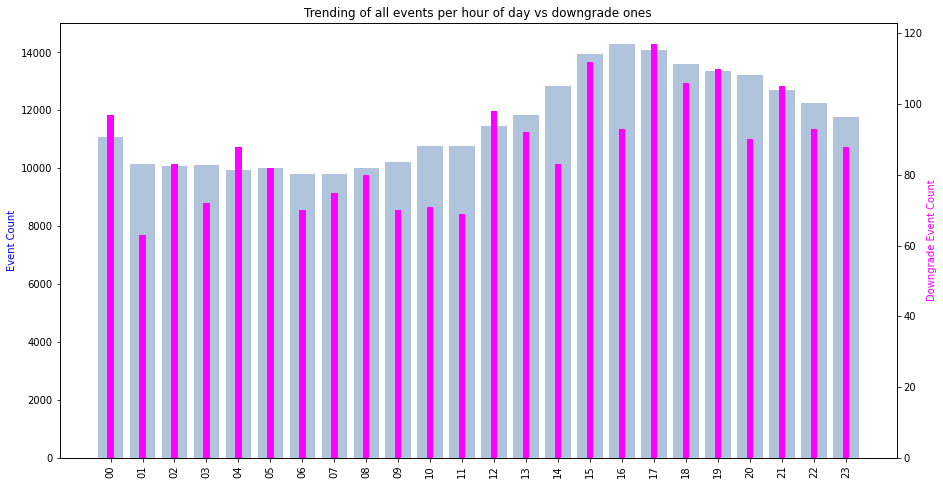

In [24]:
# analysis by hours
df4 = spark.sql("select ts_hour, count(*) as count from event_table_cleaned group by ts_hour order by ts_hour")
print(df4.show(n=5))
df_panda = df4.toPandas()
df_downgrade_cancel = spark.sql("select ts_hour, count(*) as count from event_table_cleaned where page in ('Downgrade', 'Cancel') group by ts_hour order by ts_hour")
df_downgrade_cancel_pd = df_downgrade_cancel.toPandas()


# visualize now
# Matplotlib documentation on https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.barh.html#:~:text=A%20horizontal%20bar%20plot%20is,axis%20represents%20a%20measured%20value.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize =(15, 8))

# Top chart, using twin axis to overlay on background the count of events and on foreground the downgrade count
# Using twin axis to have 2 y-axis and proportionally compare better how both are trending by hour.
ax0_twin = ax.twinx() 
ax.bar(df_panda['ts_hour'].tolist(), df_panda['count'].tolist(), color='lightsteelblue')
ax0_twin.bar(df_downgrade_cancel_pd['ts_hour'].tolist(), df_downgrade_cancel_pd['count'].tolist(), color='magenta', width=0.2)
ax.title.set_text('Trending of all events per hour of day vs downgrade ones')
ax.set_ylabel('Event Count', color = 'blue') 
ax0_twin.set_ylabel('Downgrade Event Count', color = 'magenta') 
ax.tick_params(axis='x', rotation=90)

### Time analysis insights
The data clearly seems to show a weekly seasonality, where the event count is lower over the weekend. 
<br>The event count seems also to follow hourly pattern, which intuitively makes sense... people are more keen to listen to music in the late afternoonn or evening vs the morning, the population age and hourly patterns could be, if the data was available, very interesting to analyse.
<br>Therefore, we would like to include time based features like year, month, weekday, hour as  potential useful features in our model.
<br>No clear up/down overall full duration trend is showing, but cautious is needed as it is only a subset of the data.

### Analytics on type of device used to play the songs

In [25]:
# Lets look at some data example to see how to parse the userAgent data to simplify it
df4 = spark.sql("SELECT userAgent, count(*) FROM from event_table_clean group by userAgent order by count(*) DESC")
df4.show(n = 10, truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------+-----+
|userAgent                                                                                                                         |FROM |
+----------------------------------------------------------------------------------------------------------------------------------+-----+
|"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"                   |22751|
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.77.4 (KHTML, like Gecko) Version/7.0.5 Safari/537.77.4"           |19611|
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"        |18448|
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"        |17348|
|Mozilla/5.0 (Windows NT 6.

INSIGHT: the field userAgent is very noisy, lets simplify it by only getting the values between () and the first item before the ";" or ")" or a white space.<br>Regular expressions would be ideal for this work.

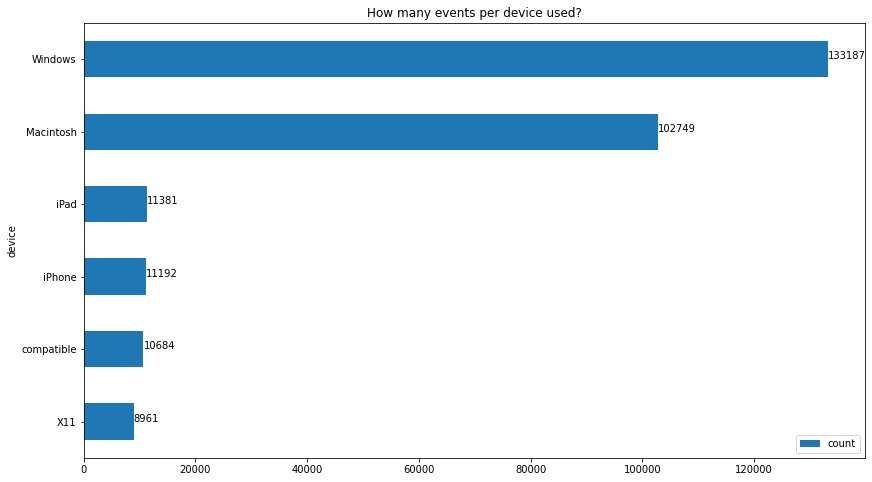

In [26]:
from pyspark.sql import functions as F
# Regex to get the first word between the first parenthesis and either ";" or ")" or a white space
# Example: "Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; rv:31.0)" => "Macintosh"
df = df.withColumn("device", F.regexp_extract(df.userAgent, r"\(([a-z|A-Z|0-9]+?)[\;|\)|\s]", 1))          
df4 = df.groupBy('device').count().select('device', 'count').orderBy('count')
df_panda = df4.toPandas()
fig, ax = plt.subplots(figsize=(14, 8))
df_panda.plot.barh(x='device', y='count', ax=ax)

# add label of value, see doc https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.text.html
for idx, value in enumerate(df_panda['count']):
    plt.text(value, idx, value)

plt.title('How many events per device used?')
plt.show()

### Deep dive on churn patterns
Lets deep dive on the data patterns linked to user churning. This to get more insights on potentially useful features and methods to use.


In [27]:
# Show me some records where user churned
df.filter("page='Cancellation Confirmation'").select('userId', 'page').show(n=3, truncate=False)

+------+-------------------------+
|userId|page                     |
+------+-------------------------+
|18    |Cancellation Confirmation|
|32    |Cancellation Confirmation|
|125   |Cancellation Confirmation|
+------+-------------------------+
only showing top 3 rows



In [28]:
# Lets look at 1 user with userId=131 by time stamp when churned
df5 = spark.sql("select ts_timestamp, page, artist, song, \
        length, level, userAgent, userID \
        from event_table_cleaned where userID = '18' order by ts_timestamp desc")
df5.show(20)

+----------------+--------------------+--------------------+--------------------+---------+-----+--------------------+------+
|    ts_timestamp|                page|              artist|                song|   length|level|           userAgent|userID|
+----------------+--------------------+--------------------+--------------------+---------+-----+--------------------+------+
|2018-10-07 08:26|Cancellation Conf...|                null|                null|     null| paid|"Mozilla/5.0 (Mac...|    18|
|2018-10-07 08:22|           Downgrade|                null|                null|     null| paid|"Mozilla/5.0 (Mac...|    18|
|2018-10-07 08:22|            NextSong|          Nickelback|             Someday|207.46404| paid|"Mozilla/5.0 (Mac...|    18|
|2018-10-07 08:22|              Cancel|                null|                null|     null| paid|"Mozilla/5.0 (Mac...|    18|
|2018-10-07 08:17|            NextSong|The Notorious B.I.G.|Nasty Girl (Featu...| 286.1971| paid|"Mozilla/5.0 (Mac...|

### How long from start to churn?

In [29]:
# Now lets define a partition over to see time span between each churn events by user
from pyspark.sql import Window
from pyspark.sql import functions as F
window = Window.partitionBy("userId")\
    .orderBy("ts_timestamp")\
    .rangeBetween(Window.unboundedPreceding, 0)

# see events in reverse chronological order to see what happens before the churn
df.where(df.userId == 18).select('userId', 'page', 'churn', 'ts_timestamp',\
    (F.col('ts') - F.first('ts').over(window)).alias('ts_churn'),\
    # F.row_number().over(window).alias('rank')\
    )\
    .orderBy(['userId', 'ts_timestamp'], ascending=[1,0])\
    .show(n=30, truncate=False)

+------+-------------------------+-----+----------------+---------+
|userId|page                     |churn|ts_timestamp    |ts_churn |
+------+-------------------------+-----+----------------+---------+
|18    |Cancellation Confirmation|1    |2018-10-07 08:26|444073000|
|18    |NextSong                 |0    |2018-10-07 08:22|443809000|
|18    |Cancel                   |0    |2018-10-07 08:22|443823000|
|18    |Downgrade                |0    |2018-10-07 08:22|443822000|
|18    |NextSong                 |0    |2018-10-07 08:17|443523000|
|18    |NextSong                 |0    |2018-10-07 08:11|443200000|
|18    |NextSong                 |0    |2018-10-07 08:07|442920000|
|18    |NextSong                 |0    |2018-10-07 08:04|442746000|
|18    |NextSong                 |0    |2018-10-07 08:00|442508000|
|18    |NextSong                 |0    |2018-10-07 07:53|442113000|
|18    |NextSong                 |0    |2018-10-07 07:48|441777000|
|18    |NextSong                 |0    |2018-10-

In [30]:
print(df.columns)

['artist', 'auth', 'firstName', 'gender', 'itemInSession', 'lastName', 'length', 'level', 'location', 'method', 'page', 'registration', 'sessionId', 'song', 'status', 'ts', 'userAgent', 'userId', 'churn', 'churn_user', 'state', 'city', 'ts_timestamp', 'ts_yyyy_mm_dd', 'ts_hour', 'ts_day_of_month', 'ts_day_of_week', 'ts_month', 'ts_year', 'ts_year_month', 'device']


INSIGHT: the user was playing a few songs, submitted his cancellation then the downgrade came, then cancellation confirmation

## Key Learnings On Field Data Aggregation Per User & Churn Visualization
In this section, we will aggregate some key features per user and analyze / visualize how the user churning or not differentiate between them. This will help us to confirm the key features to use for modelling. 
<br>We could imagine an evolved model where we build a vectorized count of number of songs played or artist played, using the SQL function "approx_count_distinct()". We could then build a related "profile" for the user, compared to other users.
<br>
<br>I coded this "user profiling" feature using a standard PySpark function "collect_list()" on songs and artist for each user. I found out that the PySpark CountVectorizercould be powerful, but very resource intensive, especially on the dimensionality of the vector createed. For the sake of simplicity and time, I changed our feature strategy to only count the distinct number of songs and artists played using the sql function "approx_count_distinct()". 
<br>I also found using spark.sql statements for data engineering easier to develop and combine than the normal Spark DataFrame methods, likely because I am very familiar the SQL and found differences on how PySpark handles dataframes vs the normal Python Pandas module.
<br>Reference to handy related Spark SQL functions:
- "approx_count_distinct(some_column)", "returns a new Column for approximate distinct count of column", but much faster than an exact count "https://spark.apache.org/docs/3.1.2/api/python/reference/api/pyspark.sql.functions.approx_count_distinct.html
- "collect_set() & collect_list", "PySpark SQL function collect_set() is similar to collect_list(). The difference is that collect_set() dedupe or eliminates the duplicates and results in uniqueness for each value" reference: https://sparkbyexamples.com/pyspark/pyspark-collect_list-and-collect_set-functions/


In [31]:
print(df.printSchema())

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- churn: integer (nullable = true)
 |-- churn_user: integer (nullable = true)
 |-- state: string (nullable = true)
 |-- city: string (nullable = true)
 |-- ts_timestamp: string (nullable = true)
 |-- ts_yyyy_mm_dd: string (nullable = true)
 |-- ts_hour: string (nullable = true)
 |-- ts_day_of_month: st

In [52]:
# Replace NAN by Null on field 'Legnth' to avoid that percentile calculation returns NAN
# Code found & updated from the following URL https://stackoverflow.com/questions/50992713/pyspark-replace-nan-with-null
df = df.withColumn('length_clean',F.when(F.isnan(F.col('length')),None).otherwise(F.col('length')))

In [33]:
# Now lets define a partition over to see time span between each churn events by user
from pyspark.sql import Window
from pyspark.sql import functions as F
window = Window.partitionBy("userId")\
    .orderBy("ts_timestamp")\
    .rangeBetween(Window.unboundedPreceding, 0)

df_user = df.select('userId', 'page', 'churn', 'ts_timestamp', 'length_clean', \
                    'level', 'gender', 'device', 'song', 'artist', \
                    'city', 'state', \
                    (F.col('ts') - F.first('ts').over(window)).alias('ts_churn'))

df_user.createOrReplaceTempView('user_ts_churn_timestamp')
sql_Query = """ select userId
    , max(churn) as churn_user
    , max(gender) as gender
    , max(device) as device
    , max(city) as city
    , max(state) as state
    , max(level) as level
    , cast(max(ts_churn)/3600000 as int) as hours_2_churn
    , count(*) as nr_events 
    , percentile(length_clean, 0.50) as length_pct_50
    , percentile(length_clean, 0.75) as length_pct_75
    , sum(case when page = "Thumbs Up" then 1 else 0 end) as thumb_up
    , sum(case when page = "Thumbs Down" then 1 else 0 end) as thumb_down
    , sum(case when page = "Add Friend" then 1 else 0 end) as add_friend
    , sum(case when page = "Downgrade" then 1 else 0 end) as downgrade
    , sum(case when page = "Upgradee" then 1 else 0 end) as upgrade
    , sum(case when page = "Add to Playlist" then 1 else 0 end) as add_playlist
    , sum(case when page = "Error" then 1 else 0 end) as Error
    , approx_count_distinct(song) as song_count
    , approx_count_distinct(artist) as artist_count
    FROM user_ts_churn_timestamp 
    GROUP BY userId
    """

df_clean = spark.sql(sql_Query)
df_clean.persist() # caching to improve performance
df_clean.show(n=10)

+------+----------+------+---------+--------------------+--------+-----+-------------+---------+------------------+------------------+--------+----------+----------+---------+-------+------------+-----+----------+------------+
|userId|churn_user|gender|   device|                city|   state|level|hours_2_churn|nr_events|     length_pct_50|     length_pct_75|thumb_up|thumb_down|add_friend|downgrade|upgrade|add_playlist|Error|song_count|artist_count|
+------+----------+------+---------+--------------------+--------+-----+-------------+---------+------------------+------------------+--------+----------+----------+---------+-------+------------+-----+----------+------------+
|100010|         0|     F|   iPhone|Bridgeport-Stamfo...|      CT| free|         1061|      381|         237.13914|         277.15873|      17|         5|         4|        0|      0|           7|    0|       274|         249|
|200002|         0|     M|   iPhone|Chicago-Napervill...|IL-IN-WI| paid|         1091|      

churn_user   0   1
gender            
F           84  20
M           89  32


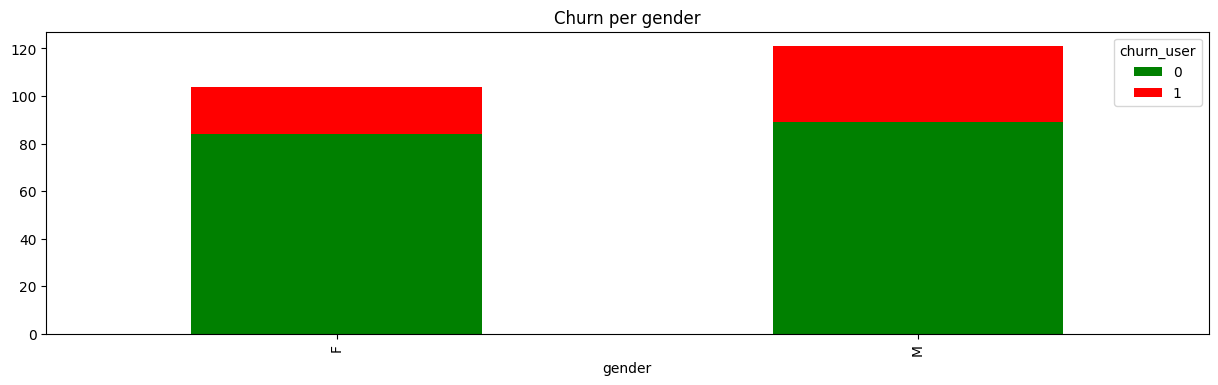

churn_user     0    1
state                
AK           2.0  NaN
AL           2.0  2.0
AR           NaN  1.0
AZ           5.0  2.0
CA          27.0  6.0


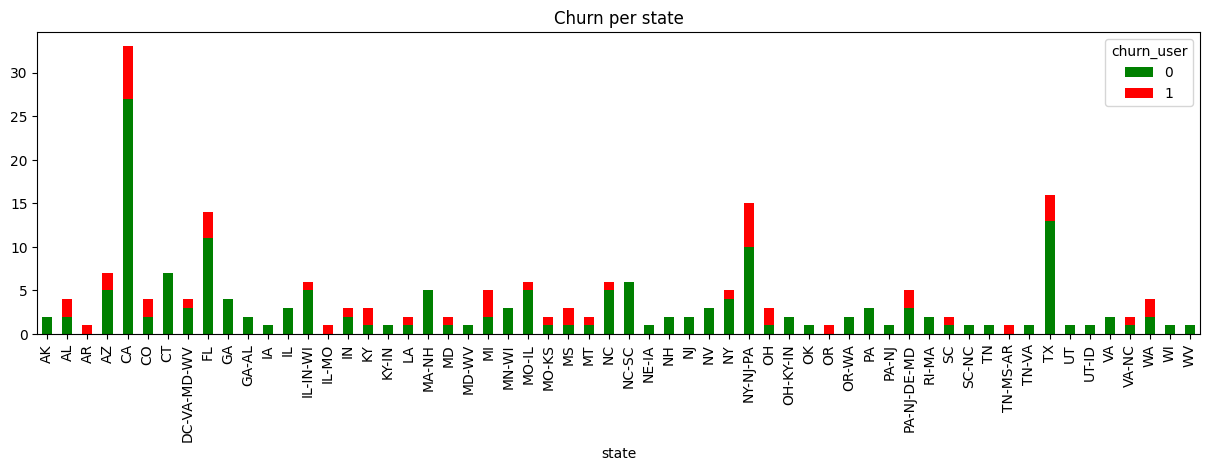

churn_user    0   1
level              
free         44  16
paid        129  36


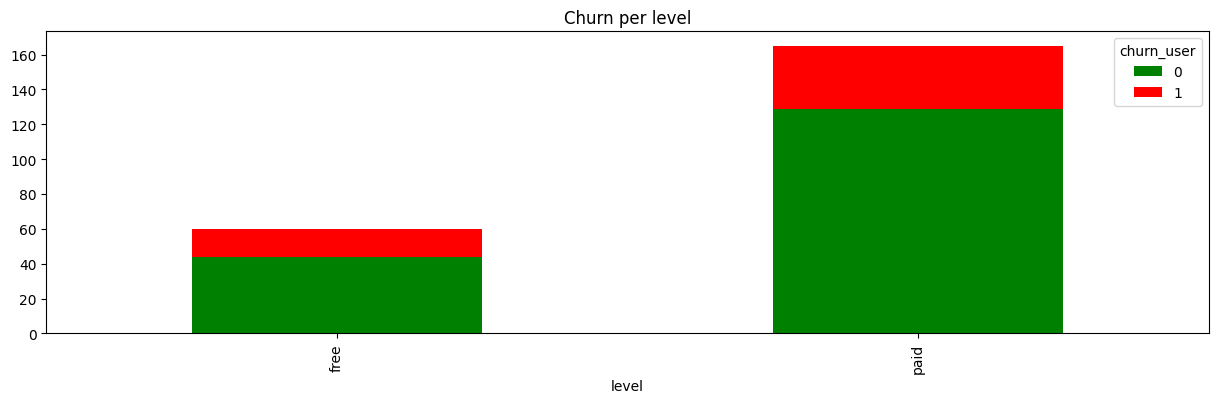

churn_user     0     1
device                
Macintosh   67.0  19.0
Windows     82.0  24.0
X11          7.0   5.0
compatible   5.0   NaN
iPad         3.0   NaN


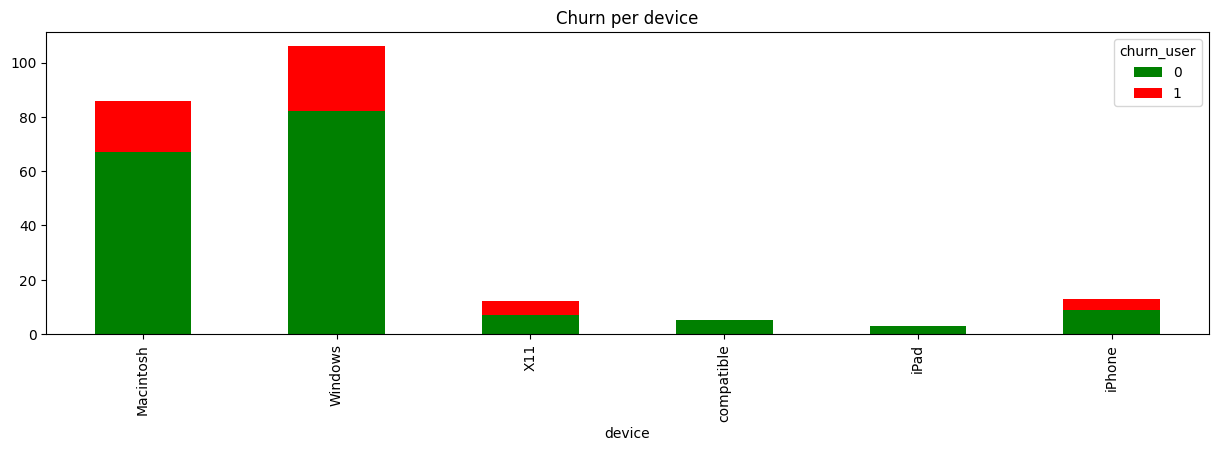

In [34]:
# Show how the churn varies between gender, state, level and type of device used
fieldList = ['gender', 'state', 'level', 'device']
for field in fieldList:
    # Get the count by the field analyzed and churn yes/not
    df4 = df_clean.select(field, 'userId', 'churn_user').groupBy(field, 'churn_user').count().orderBy(field, 'churn_user')

    # move DF to a panda dataframe and pivot it to represent it into a stacked bar chart
    dfp = df4.toPandas() # .dropna(axis=1)
    dfp = pd.pivot_table(dfp, values='count', index=field, columns='churn_user', aggfunc=np.sum)
    print(dfp.head())
    plt.rcParams['figure.figsize'] = [15, 4]
    plt.rcParams['figure.dpi'] = 100
    ax = dfp.plot.bar(color=['green','red'], stacked=True)
    plt.title(f'Churn per {field}')
    plt.show()

### Analysis of Churn
You can see intuitively from the charts that the churn proportion varies between the different values. Those fields should certainly be part of our features. 
<br>Given the very small sample size in some value categories, we can only make some observations, but no statistically valid conclusions. 
<lt>
<li>Gender: male seems to churn more than female
</li><li>States: some states (OH, AL, MS,...) have a higher churn than others
    </li><li>Level: paid people churn more than free ones
    </li><li>Device (userAgent): windows and mac are churning more than other devices, but also represents the higher proportion of users.
    

# 3 Features Engineering
In the hereunder section, the datframe will be cleansed to keep the key features we plat to use to train and test the machine learning model. 
### Feature Engineering Strategy
We will use pipeline to convert our raw feature to ML-ready features.
<br>The pipeline will follow those steps:
<ol>
<li>[churn_user] is already in binary format => no action needed
</li><li>Other categorical [gender, device, city, state, level] => indexer + bit encoder 
</li><li>Numerical values [nr_events, hours_2_churn, percentile of length 50/75%, count of thumb up/down, add friends,...] => normalize / standardize
</li><li>Concatenate all features calculated above into a vector assembler to enable a ML engine
</li><li>Run ML classification
</li></ol>
<br> We will test each type of transformation individually to ground our learnings, verify that they work and achieve the excepted outcomes.

In [35]:
print(df_clean.columns)

['userId', 'churn_user', 'gender', 'device', 'city', 'state', 'level', 'hours_2_churn', 'nr_events', 'length_pct_50', 'length_pct_75', 'thumb_up', 'thumb_down', 'add_friend', 'downgrade', 'upgrade', 'add_playlist', 'Error', 'song_count', 'artist_count']


### Categorical fields(gender, device, city, state, level) => Hot encoder

In [36]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

category_columns= ['gender', 'device', 'city', 'state', 'level']

indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c)) 
            for c in category_columns]

encoders = [OneHotEncoder(dropLast=False,inputCol=indexer.getOutputCol(),outputCol="{0}_encoded".format(indexer.getOutputCol())) 
            for indexer in indexers ]

# put all in an assembler vector & run pipeline
assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders],outputCol="category_features")
pipeline = Pipeline(stages=indexers + encoders+[assembler])
model=pipeline.fit(df_clean)
df_feature3 = model.transform(df_clean)
df_feature3.select(category_columns + ['category_features']).show(n=3, truncate=True)                                          

+------+---------+--------------------+--------+-----+--------------------+
|gender|   device|                city|   state|level|   category_features|
+------+---------+--------------------+--------+-----+--------------------+
|     F|   iPhone|Bridgeport-Stamfo...|      CT| free|(181,[1,4,25,126,...|
|     M|   iPhone|Chicago-Napervill...|IL-IN-WI| paid|(181,[0,4,13,127,...|
|     M|Macintosh|      Corpus Christi|      TX| free|(181,[0,3,69,122,...|
+------+---------+--------------------+--------+-----+--------------------+
only showing top 3 rows



### Numerical values (hours_2_churn & nr_events) => StandardScaler
First we put the numerical values into a vector then we scale it to fit a std deviation of 1 and mean of 1. This will be done at the end also for our categorical and list of string values transformed to vectors

In [37]:
from pyspark.ml.feature import StandardScaler
numerical_columns = ['hours_2_churn', 'nr_events', 'length_pct_50', 'length_pct_75', 'thumb_up', 'thumb_down', 'add_friend', 'downgrade', 'upgrade', 'add_playlist', 'Error', 'song_count', 'artist_count']
# Get values into a vector
assembler = VectorAssembler(inputCols=numerical_columns, outputCol="vec_Numerical")
df_clean2 = assembler.transform(df_clean)
df_clean2.select('hours_2_churn', 'nr_events', 'vec_Numerical').show(n=3)

+-------------+---------+--------------------+
|hours_2_churn|nr_events|       vec_Numerical|
+-------------+---------+--------------------+
|         1061|      381|[1061.0,381.0,237...|
|         1091|      474|[1091.0,474.0,237...|
|            0|       11|(13,[1,2,3,11,12]...|
+-------------+---------+--------------------+
only showing top 3 rows



In [38]:
# Scale the vecto to a standard normal distribution
scaler = StandardScaler(inputCol='vec_Numerical', outputCol=f'scalled_numerical', \
                       withStd=True, withMean=True)
sc_model = scaler.fit(df_clean2)
df_scaled = sc_model.transform(df_clean2)
df_scaled.select('userId', 'hours_2_churn', 'nr_events', f'scalled_numerical').show(n=3, truncate=False)

+------+-------------+---------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|userId|hours_2_churn|nr_events|scalled_numerical                                                                                                                                                                                                                                  |
+------+-------------+---------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|100010|1061         |381      |[0.14221430163646376,-0.6432640827063776,0.6967862070660079,0.032329707509616126,-0.5922946161438025,-0.4829336348711395,-0.7292340618073

# 4.Modeling
In this section, the full dataset will be randomly split into train, test, and validation sets and prepared through "feature engineering" to be ready for ML modeling. 
<br>Then several machine learning classifiers will be trained on the training data set and evaluated for model performance, tuning their parameters to optimize their performance.
<br>The winning model will be picked based on test accuracy and its prediction checked on the validation set. 

In [39]:
# Lets check the latest schema
print(df_clean.printSchema())

root
 |-- userId: string (nullable = true)
 |-- churn_user: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- device: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- level: string (nullable = true)
 |-- hours_2_churn: integer (nullable = true)
 |-- nr_events: long (nullable = false)
 |-- length_pct_50: double (nullable = true)
 |-- length_pct_75: double (nullable = true)
 |-- thumb_up: long (nullable = true)
 |-- thumb_down: long (nullable = true)
 |-- add_friend: long (nullable = true)
 |-- downgrade: long (nullable = true)
 |-- upgrade: long (nullable = true)
 |-- add_playlist: long (nullable = true)
 |-- Error: long (nullable = true)
 |-- song_count: long (nullable = false)
 |-- artist_count: long (nullable = false)

None


## ML Model Training And Tuning
We will first develop a pipeline to consolidate all our numerical and categorical features and transform them into a ML compatible assembled vector "feature".
For details on the ML models used hereunder, please refer to the excellent PySpark ML Classification documentation on https://spark.apache.org/docs/latest/ml-classification-regression.html

### Building The ML Pipeline For Features
Reference: https://spark.apache.org/docs/latest/ml-pipeline.html

In [40]:
# transform played song list for each user to a count vectorizer, to be used as a feature
from pyspark.ml.feature import CountVectorizer, IDF, StringIndexer, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression

# 0) GET THE LABEL
df_clean= df_clean.withColumn("label", df_clean['churn_user'])

# 1) NUMERICAL VALUES: vector => standard scaller
numerical_columns = ['hours_2_churn', 'nr_events', 'length_pct_50', 'length_pct_75', \
                     'thumb_up', 'thumb_down',\
                     'add_friend', 'downgrade', 'upgrade', 'add_playlist',\
                     'Error', 'song_count', 'artist_count']

numericAssembler = VectorAssembler(inputCols= numerical_columns, outputCol="numeric_Features")
numericScaler = StandardScaler(inputCol='numeric_Features', outputCol='sc_numeric_Features', \
                       withStd=True, withMean=True)

feature_columns = ['sc_numeric_Features']
  
## 2) CATEGORICAL FIELDS: transforming the categorical columns to a hotencoder vector
categorical_columns= ['gender', 'device', 'city', 'state', 'level']
# how to handle invalid data (unseen or NULL values) in features 
# and label column of string type. Options are 'skip' (filter out rows with invalid data),
# error (throw an error), or 'keep' (put invalid data in a special additional bucket, at index numLabels)."
indexers = [StringIndexer(inputCol=c,\
                          outputCol="{0}_indexed".format(c),\
                          handleInvalid="keep")\
            for c in categorical_columns]

encoders = [OneHotEncoder(dropLast=False,inputCol=indexer.getOutputCol(),\
               outputCol='{0}_encoded'.format(indexer.getOutputCol())) \
            for indexer in indexers]

categorical_columns = [encoder.getOutputCol() for encoder in encoders] 
feature_columns = feature_columns + categorical_columns

## put 1) + 2) in an assembler vector & run pipeline
assembler = VectorAssembler(inputCols= feature_columns, outputCol="features")

# Build the pipeline to join the feature vectors of numericals + list of strings + categoricals, but no classifcation model at the end
featurePipeline = Pipeline(stages=[numericAssembler, numericScaler]\
                    + indexers + encoders \
                    + [assembler])

featureModel = featurePipeline.fit(df_clean)
df_ML_features = featureModel.transform(df_clean).select('userId', 'label', 'features')

In [41]:
df_ML_features.show(n=2, truncate=False)

+------+-----+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|userId|label|features                                                                                                                                                                                                                                                                                                               |
+------+-----+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|100010|0    |(199,

### Splitting the data set into training & testing data

In [42]:
train, test = df_ML_features.randomSplit([0.8, 0.2], seed=42)
print(f'Train records count: {train.count()}\tTest: {test.count()}')

Train records count: 188	Test: 37


### How will we evaluate our model efficacy?
Lets look first at the distribution of our "churn" binary label values to classify and see if they are balanced between the users "churning" (churn_user=1) and "not churning"(churn_user=0).

   churn_user  count
0           1     52
1           0    173


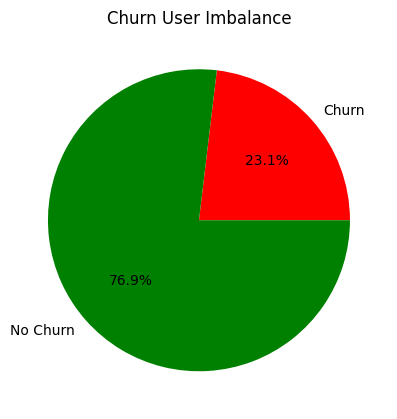

In [47]:
# Get the count by the field analyzed and churn yes/not
df4 = df_clean.select('userId', 'churn_user').groupBy('churn_user').agg(count('userId').alias('count')).sort(desc('churn_user'))
                                                                                              
# move DF to a panda dataframe and pivot it to represent it into a stacked bar chart
dfp = df4.toPandas() # .dropna(axis=1)
#dfp = pd.pivot_table(dfp, values='count', index='churn_user', columns='churn_user', aggfunc=np.sum)
print(dfp.head())
plt.rcParams['figure.figsize'] = [5, 5]
plt.rcParams['figure.dpi'] = 100
my_color = ['red', 'green']
plt.pie( dfp['count'], labels = ['Churn', 'No Churn'], colors=my_color,  autopct='%.1f%%')
plt.title(f'Churn User Imbalance')
plt.show()

<b>Our label distribution is highly skewed</b> with only 23% of users churning vs 77% not churning. Therefore accuracy (% of predicted label as the actual label) is not a good measure of the model performance, as having a simplistic model saying the label always returning "not churning", will already have accuracy of 70%.
<br>
<br><b>The F1 score is much more relevant for our problem</b> as it takes into account the true/false positive and true/false negative to calculate the F1 score.
<br>F1 score Wikipedia definition: "<i>In statistical analysis of binary classification, the F-score or F-measure is a measure of a test's accuracy. It is calculated from the precision and recall of the test, where the precision is the number of true positive results divided by the number of all positive results, including those not identified correctly, and the recall is the number of true positive results divided by the number of all samples that should have been identified as positive. Precision is also known as positive predictive value, and recall is also known as sensitivity in diagnostic binary classification. The F1 score is the harmonic mean of the precision and recall. It thus symmetrically represents both precision and recall in one metric."</i>
Reference: https://en.wikipedia.org/wiki/F-score
<br>
<br><b>The Crossvalidator and its parameterGrid</b> will be used to iterate the model and fine tune its parameters: 
<i>"K-fold cross validation performs model selection by splitting the dataset into a set of non-overlapping randomly partitioned folds which are used as separate training and test datasets e.g., with k=3 folds, K-fold cross validation will generate 3 (training, test) dataset pairs, each of which uses 2/3 of the data for training and 1/3 for testing. Each fold is used as the test set exactly once."
</i> Reference: https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.ml.tuning.CrossValidator.html

### Class To Fit, Tune & Evaluate Different Classifier Models & F1 Scoring
We will create our own reusable generic Python model evaluation class that we can use to train, tune and evaluate the F1 score of those classifier models.
The Spark "CrossValidator" and "ParametersGrid" will be leveraged to search for the optimimal parameters for each classifier.
- LogisticRegression
- LinearSVC
- GBTClassifier
- RandomForestClassifier

In [48]:
class ModelEvaluator:
    """ Class to fit an ML model classifier on a train dataframe 
    and tune its parameters using a Crossvalidator and a grid of parameters
    based on the model f1 score.
    
    INPUT: 
        df_train: dataframe used to train the model
        df_test: dataframe used to test the model
        modelName: model name
        modelClassifier: classifier Model used
        paramGrid:  ParamGridBuilder object with the grid parameter to fine the optimum parameters for the model

    OUTPUT stored in the object:
        trained model
        f1Score based on the test dataframe
        fittingTime in seconds
        bestParameters used in the grid parameters returned by the CrossValidator for the "best model"
        performance: a dictonary with a summary of the model evaluation
            
    """

    
    def __init__(self, df_train, df_test, modelName, modelClassifier, paramGrid):
        """ Instantiation of the object """
        
        self.modelName = modelName
        self.modelClassifier = modelClassifier
        self.paramGrid = paramGrid
        self.pipeline =  Pipeline(stages=[self.modelClassifier])
        self.crossVal = CrossValidator(estimator=self.pipeline, \
                                 estimatorParamMaps=self.paramGrid, \
                                 evaluator=MulticlassClassificationEvaluator(metricName='f1'), \
                                 numFolds=3,\
                                 parallelism=2,\
                                 seed=42)

        # Fit the model and time its fitting
        startTime = time.time()
        self.model = self.crossVal.fit(df_train)
        endTime = time.time()
        self.fittingTime = endTime - startTime
        self.bestParameters = self.model.bestModel.extractParamMap()
                
        # Get performance metrics on the model for each parameter combinations on the grid
        print(f'\n###> Model {modelName} ran in {self.fittingTime :1.1f} seconds <###')
        
        # I note that the model.avgMetrics features varies between the AWS Spark v3.1 vs the Udacity Spark v2.4 platform when running on both.
        try:
            self.avgTrainMetrics = self.model.avgMetrics
            self.f1score_parameters = list(map(list, zip(model.avgTrainMetrics, model.paramGrid))).sort()
            print(f'Average F1 Score metrics & Parameters for the TRAIN dataset:\n{self.f1score_parameters}')
            
        except:
            self.avgTrainMetrics = "No available in this PySpark version"
            self.f1score_parameters = "No available in this PySpark version"
        
        # Check the model F1 score for the TEST dataset
        df_predict = self.model.transform(df_test)
        self.evaluator = MulticlassClassificationEvaluator(metricName='f1')
        self.f1Score = float(self.evaluator.evaluate(df_predict.select('label', 'prediction')))
        print(f'F1 Score for the TEST dataset: {self.f1Score:1.4f}')
        
        # Get a summary of the fitting/testing result in a nice dictionary
        self.performance = {"classifier_name":self.modelName, "Test_f1_score":self.f1Score, \
                            "fitting_time":self.fittingTime, "parameters":self.paramGrid, \
                            "Average_Train_f1_score":self.avgTrainMetrics}       
        
        print(self.performance)

In [49]:
model_list = []

### Log Regression Model
Reference: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.LogisticRegression.html

In [50]:
logRegression = LogisticRegression(maxIter=5, regParam=0.0, elasticNetParam=0)
paramGrid = ParamGridBuilder() \
    .addGrid(logRegression.regParam, [0.0, 0.1])\
    .addGrid(logRegression.maxIter, [2, 3])\
    .build()

model_list.append(ModelEvaluator(train, test, modelName='LogRegression', modelClassifier=logRegression, paramGrid=paramGrid))



###> Model LogRegression ran in 166.1 seconds <###
Average F1 Score metrics & Parameters for the TRAIN dataset:
No available in this PySpark version
F1 Score for the TEST dataset: 0.6389
{'classifier_name': 'LogRegression', 'Test_f1_score': 0.6389131066550422, 'fitting_time': 166.14520406723022, 'parameters': [{Param(parent='LogisticRegression_74ccee553dec', name='regParam', doc='regularization parameter (>= 0).'): 0.0, Param(parent='LogisticRegression_74ccee553dec', name='maxIter', doc='max number of iterations (>= 0).'): 2}, {Param(parent='LogisticRegression_74ccee553dec', name='regParam', doc='regularization parameter (>= 0).'): 0.0, Param(parent='LogisticRegression_74ccee553dec', name='maxIter', doc='max number of iterations (>= 0).'): 3}, {Param(parent='LogisticRegression_74ccee553dec', name='regParam', doc='regularization parameter (>= 0).'): 0.1, Param(parent='LogisticRegression_74ccee553dec', name='maxIter', doc='max number of iterations (>= 0).'): 2}, {Param(parent='LogisticR

### Linear Support Vector Machine Model
Reference: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.LinearSVC.html

In [51]:
linSVC = LinearSVC(maxIter=5, regParam=0.0)
paramGrid = ParamGridBuilder() \
    .addGrid(linSVC.regParam, [0.0, 0.1]) \
    .build()

model_list.append(ModelEvaluator(train, test, modelName='linearSVC', modelClassifier=linSVC, paramGrid=paramGrid))


###> Model linearSVC ran in 310.0 seconds <###
Average F1 Score metrics & Parameters for the TRAIN dataset:
No available in this PySpark version
F1 Score for the TEST dataset: 0.6705
{'classifier_name': 'linearSVC', 'Test_f1_score': 0.6705276705276705, 'fitting_time': 309.9888370037079, 'parameters': [{Param(parent='LinearSVC_57be23a8ddc3', name='regParam', doc='regularization parameter (>= 0).'): 0.0}, {Param(parent='LinearSVC_57be23a8ddc3', name='regParam', doc='regularization parameter (>= 0).'): 0.1}], 'Average_Train_f1_score': 'No available in this PySpark version'}


### RandomForestClassifier Model
Reference: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.mllib.tree.RandomForest.html

In [53]:
randomForest = RandomForestClassifier(numTrees=10, maxDepth=5)
paramGrid = ParamGridBuilder() \
    .addGrid(randomForest.numTrees, [10, 15]) \
    .addGrid(randomForest.maxDepth, [3, 5]) \
    .build()

model_list.append(ModelEvaluator(train, test, modelName='Random Forest', modelClassifier=randomForest, paramGrid=paramGrid))


###> Model Random Forest ran in 299.3 seconds <###
Average F1 Score metrics & Parameters for the TRAIN dataset:
No available in this PySpark version
F1 Score for the TEST dataset: 0.5800
{'classifier_name': 'Random Forest', 'Test_f1_score': 0.58000858000858, 'fitting_time': 299.3133842945099, 'parameters': [{Param(parent='RandomForestClassifier_8c7907f6401b', name='numTrees', doc='Number of trees to train (>= 1).'): 10, Param(parent='RandomForestClassifier_8c7907f6401b', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 3}, {Param(parent='RandomForestClassifier_8c7907f6401b', name='numTrees', doc='Number of trees to train (>= 1).'): 10, Param(parent='RandomForestClassifier_8c7907f6401b', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5}, {Param(parent='RandomForestClassifier_8c7907f6401b', name='numTrees', do

### Gradient Boost Trees Model
Reference: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.GBTClassifier.html

In [54]:
gbt = GBTClassifier(maxIter=5, maxDepth=2)
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [10, 15]) \
    .build()

model_list.append(ModelEvaluator(train, test, modelName='Gradient Boost Tree', modelClassifier=gbt, paramGrid=paramGrid))


###> Model Gradient Boost Tree ran in 574.8 seconds <###
Average F1 Score metrics & Parameters for the TRAIN dataset:
No available in this PySpark version
F1 Score for the TEST dataset: 0.8629
{'classifier_name': 'Gradient Boost Tree', 'Test_f1_score': 0.8629222214127874, 'fitting_time': 574.7701890468597, 'parameters': [{Param(parent='GBTClassifier_bdec4c6307cf', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 10}, {Param(parent='GBTClassifier_bdec4c6307cf', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 15}], 'Average_Train_f1_score': 'No available in this PySpark version'}


### Lets Compare Our Classifier models 
Bringing all models key collected data as dictionary to a dataframe table to easily compare each model and review their parameters.

In [58]:
from IPython.display import display, HTML

In [61]:
df = pd.DataFrame.from_records([model.performance for model in model_list])
display(df[['classifier_name', 'Test_f1_score', "fitting_time", "parameters"]])

,classifier_name,Test_f1_score,fitting_time,parameters
0,LogRegression,0.638913,166.145204,[{LogisticRegression_74ccee553dec__regParam: 0...
1,linearSVC,0.670528,309.988837,"[{LinearSVC_57be23a8ddc3__regParam: 0.0}, {Lin..."
2,Random Forest,0.580009,299.313384,[{RandomForestClassifier_8c7907f6401b__numTree...
3,Gradient Boost Tree,0.862922,574.770189,"[{GBTClassifier_bdec4c6307cf__maxDepth: 10}, {..."


The hereunder scatter plot compares each model on 2 dimensions: y_axis=f1_score vs x_axis=fitting_time. 
<br><b>Conclusion:</b>The Gradient Boost Tree is clearly the highest F1 score, but also much longer to calculate.
<br>Reference: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html

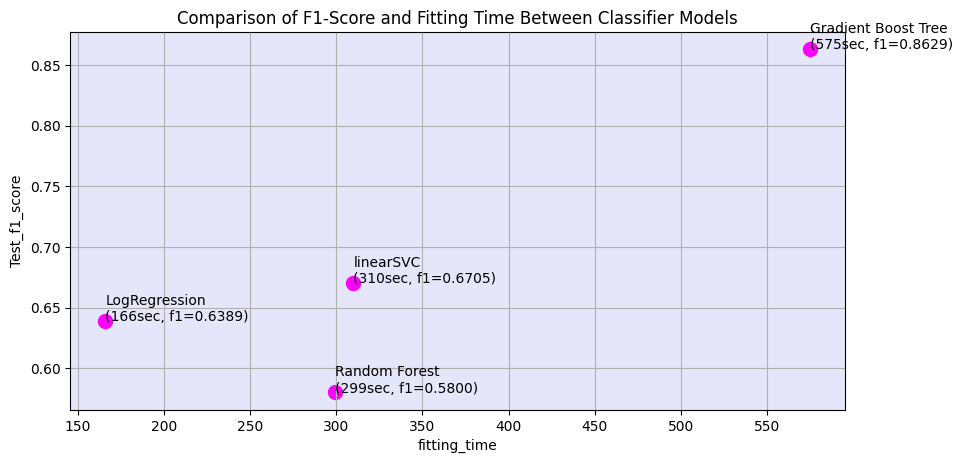

In [62]:
# Lets visualize
fig, ax = plt.subplots(figsize=(10,5)) 
ax.set_facecolor("lavender")
df.plot.scatter(x = 'fitting_time', y = 'Test_f1_score', ax = ax, color='magenta', s=100) 
plt.title('Comparison of F1-Score and Fitting Time Between Classifier Models')
# Annotate each data point
for i, name in enumerate(df.classifier_name):
    x = df.fitting_time.iat[i]
    y = df.Test_f1_score.iat[i]
    ax.annotate(f'{name}\n({x:1.0f}sec, f1={y:1.4f})', (x + 0.05, y))
plt.grid()
plt.show()

# How to further enhance the model?
The model could test more advanced features and see if they help to enhance the score. Some examples:  
<lt>
<li>Profile the user with a vector count of songs and artists played
</li><li>% of the full lenght song played
</li><li>Pattern of usage by hours of day, day of week or day of month
</li><li>Daily frequency of events and related moving average the last 2 weeks or other duration.
</li><li>Etc.
</li></lt>
<br>The model could also be optimized by using PCA or other techniques to reduce the dimensionality and also features not adding to the score.

# 5.Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.